# Netflix Data Cleaning, Analysis & Visualization

**Objective:**  
Analyze the Netflix titles dataset to understand content distribution, genre popularity, country contributions, and trends over time.

**Key Skills:**  
Data cleaning · Exploratory Data Analysis (EDA) · Visualization · Python (pandas, matplotlib, seaborn, wordcloud)



In [26]:
# Cell 1: imports
# Import core data science libraries for analysis and visualization

import os
import pandas as pd # pandas - data handling, numpy - numerical ops, seaborn/matplotlib - visualizations
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud # WordCloud - for text visualization
# plotting defaults
sns.set_theme(style="whitegrid")
plt.rcParams['figure.dpi'] = 120

# Create output folders if not present
os.makedirs("plots", exist_ok=True)
print("Libraries ready and plots/ folder exists.")


Libraries ready and plots/ folder exists.


## About the Dataset
The dataset contains information about movies and TV shows available on Netflix, including:
- Title, Director, Cast, Country
- Date added and Release year
- Rating, Duration, and Genre (`listed_in`)

**Source:** Netflix Titles Dataset (Kaggle)


In [14]:
# Cell 2: load dataset (update path if needed)
# If the CSV is in the same folder: "netflix_titles.csv"
df = pd.read_csv("netflix1.csv")
df.head()


,show_id,type,title,director,country,date_added,release_year,rating,duration,listed_in
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,United States,9/25/2021,2020,PG-13,90 min,Documentaries
1,s3,TV Show,Ganglands,Julien Leclercq,France,9/24/2021,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act..."
2,s6,TV Show,Midnight Mass,Mike Flanagan,United States,9/24/2021,2021,TV-MA,1 Season,"TV Dramas, TV Horror, TV Mysteries"
3,s14,Movie,Confessions of an Invisible Girl,Bruno Garotti,Brazil,9/22/2021,2021,TV-PG,91 min,"Children & Family Movies, Comedies"
4,s8,Movie,Sankofa,Haile Gerima,United States,9/24/2021,1993,TV-MA,125 min,"Dramas, Independent Movies, International Movies"


## Data Cleaning
Steps performed:
1. Removed duplicate records.
2. Handled missing values (`director`, `cast`, `country`, etc.) by filling them with `'Unknown'`.
3. Converted `date_added` to datetime format.
4. Extracted new columns: `year_added`, `month_added`.
5. Counted the number of genres per title.


In [15]:
# Cell 3: quick shape & info
print("Rows, Columns:", df.shape)
display(df.info())
display(df.isnull().sum())


Rows, Columns: (8790, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8790 entries, 0 to 8789
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8790 non-null   object
 1   type          8790 non-null   object
 2   title         8790 non-null   object
 3   director      8790 non-null   object
 4   country       8790 non-null   object
 5   date_added    8790 non-null   object
 6   release_year  8790 non-null   int64 
 7   rating        8790 non-null   object
 8   duration      8790 non-null   object
 9   listed_in     8790 non-null   object
dtypes: int64(1), object(9)
memory usage: 686.8+ KB


None

show_id         0
type            0
title           0
director        0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
dtype: int64

## Exploratory Data Analysis (EDA)
We explored the cleaned data to answer key business questions:

1. What is the ratio of Movies vs TV Shows?  
2. Which countries produce the most content?  
3. What are the most popular genres?  
4. How has content grown over the years?  
5. What are the most common ratings?  
6. Who are the most featured directors?


In [16]:
# Cell 4: cleaning
df = df.copy()  # work on a copy for safety

# 1) Drop duplicate rows
before = df.shape[0]
df.drop_duplicates(inplace=True)
after = df.shape[0]
print(f"Dropped {before-after} duplicate rows.")

# 2) Strip text columns if object dtype
for c in df.select_dtypes(include='object').columns:
    df[c] = df[c].astype(str).str.strip()

# 3) Replace empty strings and 'nan' strings with actual NaN
df.replace({'': np.nan, 'nan': np.nan, 'None': np.nan}, inplace=True)

# 4) Fill some columns with 'Unknown' where missing
for col in ['director', 'cast', 'country', 'rating', 'date_added']:
    if col in df.columns:
        df[col].fillna('Unknown', inplace=True)

# 5) date_added -> datetime (coerce errors)
if 'date_added' in df.columns:
    df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')

# 6) Year and month extracted from date_added, if available
df['year_added'] = df['date_added'].dt.year
df['month_added'] = df['date_added'].dt.month

# 7) Create num_genres feature (count of genres)
if 'listed_in' in df.columns:
    df['num_genres'] = df['listed_in'].apply(lambda x: len(str(x).split(',')) if pd.notnull(x) else 0)

# 8) Convert release_year to int if present
if 'release_year' in df.columns:
    df['release_year'] = pd.to_numeric(df['release_year'], errors='coerce').astype('Int64')

print("Cleaning done. Null counts now:")
display(df.isnull().sum())


Dropped 0 duplicate rows.
Cleaning done. Null counts now:


C:\Users\anjus\AppData\Local\Temp\ipykernel_7140\2155501203.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna('Unknown', inplace=True)


show_id         0
type            0
title           0
director        0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
year_added      0
month_added     0
num_genres      0
dtype: int64

## Exploratory Data Analysis (plots and commentary)
We will:
1. Compare counts of Movies vs TV Shows.
2. Show rating distribution.
3. Top countries producing content.
4. Top genres.
5. Titles added over time (year).
6. Director counts (top).
7. Word cloud for titles.


## Key Findings
1. **Content mix:** Movies dominate the platform, making up the majority of titles.  
2. **Top producing countries:** USA and India contribute the largest share of content.  
3. **Popular genres:** Drama, Comedy, and International TV Shows are the most common.  
4. **Growth trend:** There is a sharp increase in content after 2015, showing Netflix's expansion phase.  
5. **Ratings distribution:** Most titles fall in TV-MA and TV-14 categories.  
6. **Directors:** A few directors have multiple projects on Netflix, indicating partnerships or frequent collaborations.


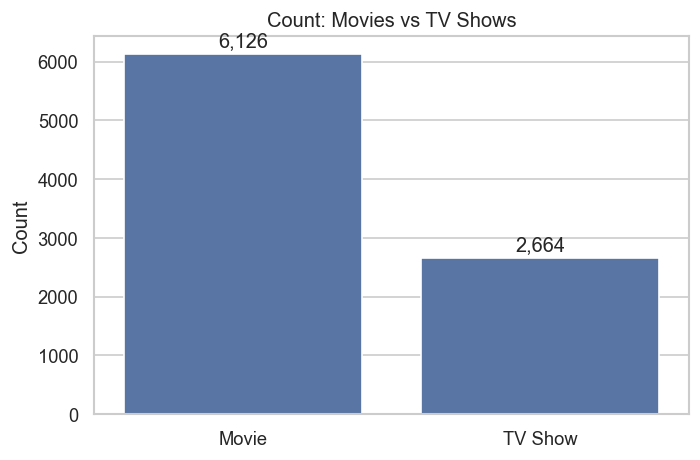

In [17]:
# Cell 5: Movies vs TV Shows
if 'type' in df.columns:
    plt.figure(figsize=(6,4))
    ax = sns.countplot(data=df, x='type', order=df['type'].value_counts().index)
    plt.title('Count: Movies vs TV Shows')
    plt.xlabel('')
    plt.ylabel('Count')
    for p in ax.patches:
        ax.annotate(format(int(p.get_height()), ','), (p.get_x()+p.get_width()/2., p.get_height()),
                    ha='center', va='center', xytext=(0, 8), textcoords='offset points')
    plt.tight_layout()
    plt.savefig("plots/movies_vs_tv.png")
    plt.show()


## Business Recommendations
- Focus on expanding high-performing genres like Drama and International TV Shows.  
- Continue investing in regional content to attract diverse audiences.  
- Highlight popular directors and regions in marketing campaigns.  
- Track yearly trends to optimize content acquisition strategies.


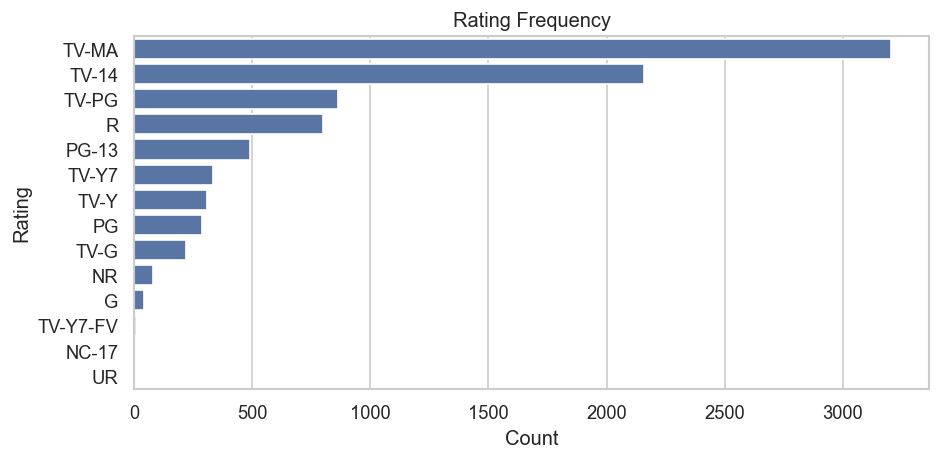

In [18]:
# Cell 6: Rating distribution
if 'rating' in df.columns:
    plt.figure(figsize=(8,4))
    order = df['rating'].value_counts().index
    sns.countplot(data=df, y='rating', order=order)
    plt.title('Rating Frequency')
    plt.xlabel('Count')
    plt.ylabel('Rating')
    plt.tight_layout()
    plt.savefig("plots/rating_distribution.png")
    plt.show()


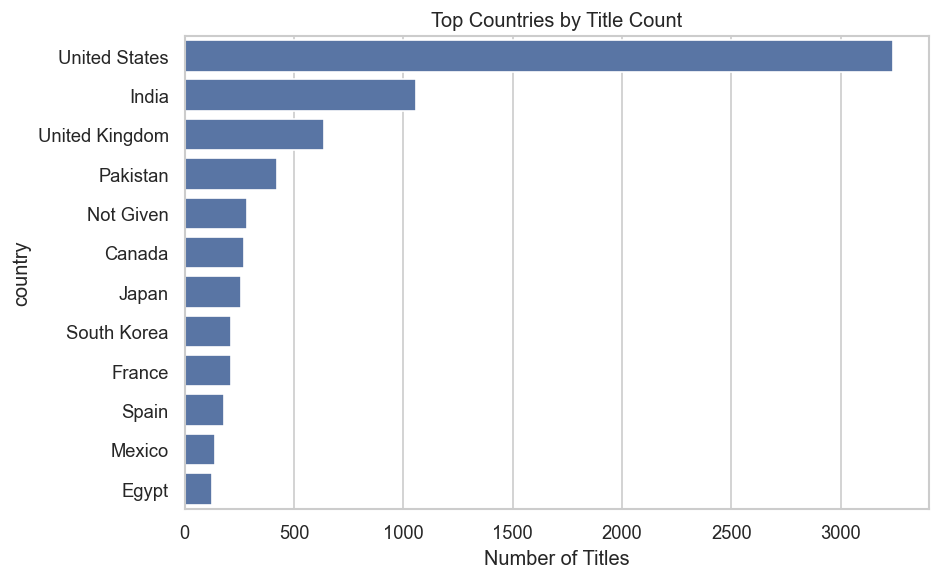

In [19]:
# Cell 7: Top countries
if 'country' in df.columns:
    # Some rows may have multiple countries separated by commas
    countries = df['country'].dropna().str.split(',').explode().str.strip()
    top_countries = countries.value_counts().head(12)
    plt.figure(figsize=(8,5))
    sns.barplot(x=top_countries.values, y=top_countries.index)
    plt.title('Top Countries by Title Count')
    plt.xlabel('Number of Titles')
    plt.tight_layout()
    plt.savefig("plots/top_countries.png")
    plt.show()


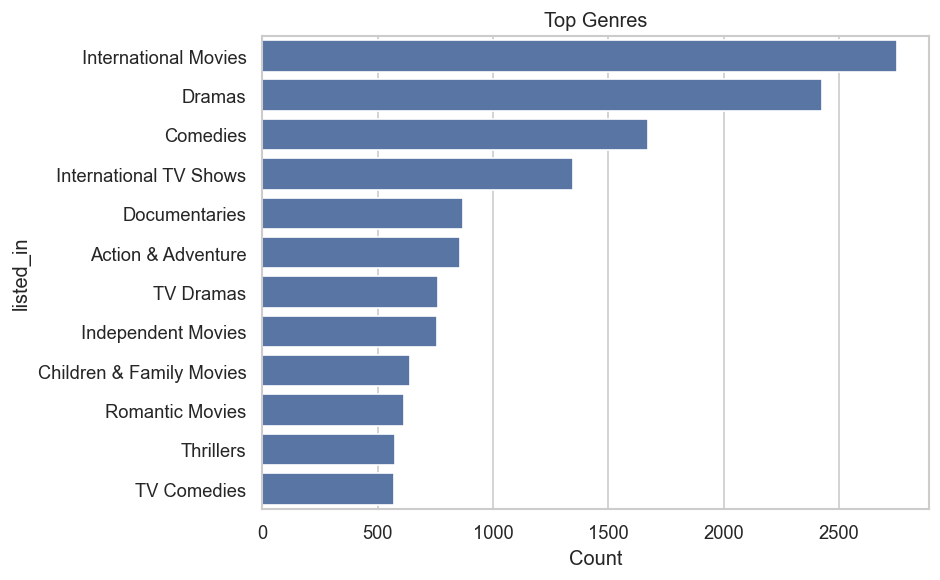

In [20]:
# Cell 8: Top genres (explode listed_in)
if 'listed_in' in df.columns:
    genres = df['listed_in'].dropna().str.split(',').explode().str.strip()
    top_genres = genres.value_counts().head(12)
    plt.figure(figsize=(8,5))
    sns.barplot(x=top_genres.values, y=top_genres.index)
    plt.title('Top Genres')
    plt.xlabel('Count')
    plt.tight_layout()
    plt.savefig("plots/top_genres.png")
    plt.show()


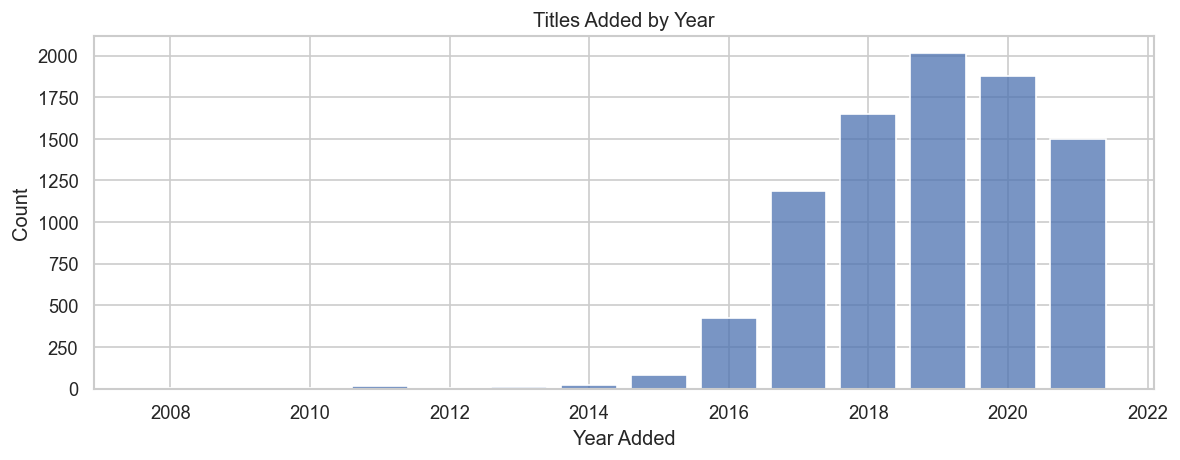

In [21]:
# Cell 9: Titles added by year
if 'year_added' in df.columns:
    # drop NaN years
    years = df['year_added'].dropna().astype(int)
    plt.figure(figsize=(10,4))
    sns.histplot(years, discrete=True, shrink=0.8)
    plt.title('Titles Added by Year')
    plt.xlabel('Year Added')
    plt.tight_layout()
    plt.savefig("plots/titles_by_year.png")
    plt.show()


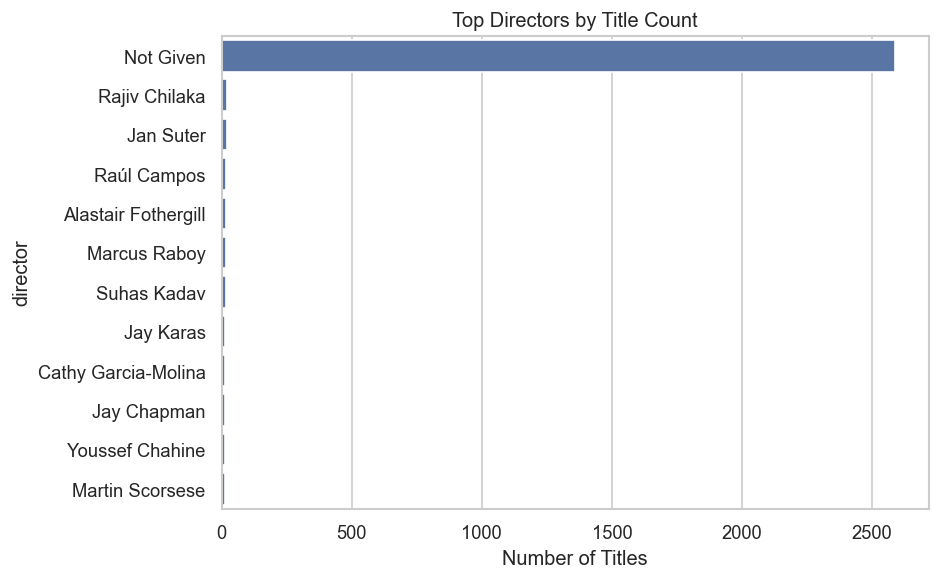

In [22]:
# Cell 10: Top directors
if 'director' in df.columns:
    dirs = df['director'].replace('Unknown', np.nan).dropna().str.split(',').explode().str.strip()
    top_dirs = dirs.value_counts().head(12)
    plt.figure(figsize=(8,5))
    sns.barplot(x=top_dirs.values, y=top_dirs.index)
    plt.title('Top Directors by Title Count')
    plt.xlabel('Number of Titles')
    plt.tight_layout()
    plt.savefig("plots/top_directors.png")
    plt.show()


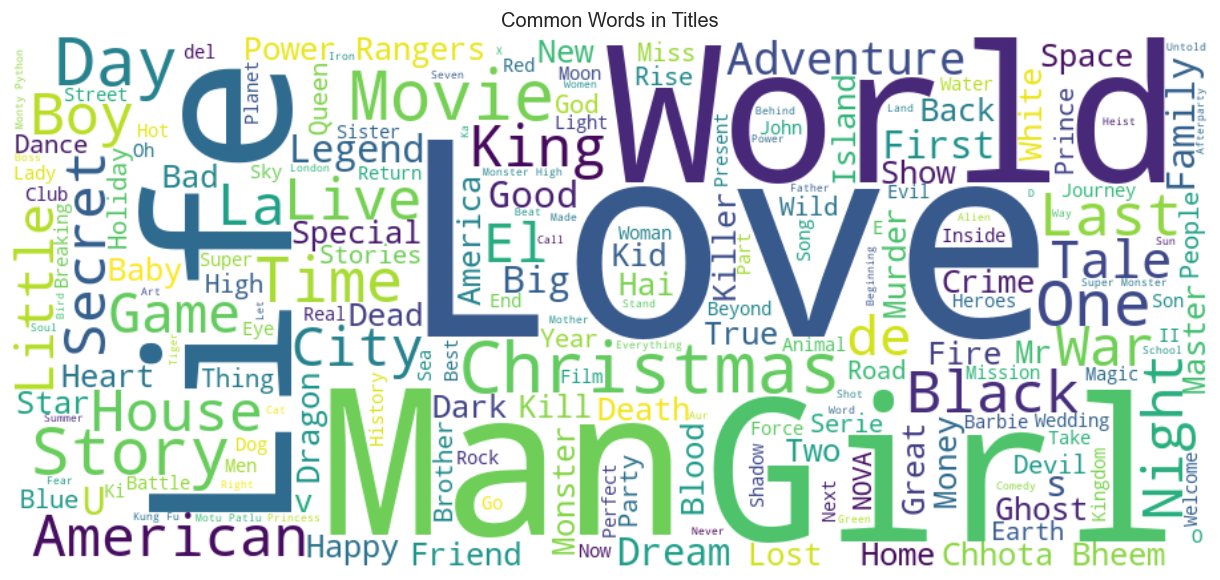

In [23]:
# Cell 11: Word cloud for titles
if 'title' in df.columns:
    text = " ".join(df['title'].astype(str).tolist())
    wc = WordCloud(width=900, height=400, background_color='white', max_words=200).generate(text)
    plt.figure(figsize=(12,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title('Common Words in Titles')
    plt.tight_layout()
    plt.savefig("plots/wordcloud_titles.png")
    plt.show()


In [24]:
# Cell 12: Save cleaned dataset
df.to_csv("netflix_cleaned.csv", index=False)
print("Saved cleaned dataset to netflix_cleaned.csv")


Saved cleaned dataset to netflix_cleaned.csv


### Key Findings (Example)
1. **Content mix:** Movies make up the majority of titles (approx. X% vs Y% TV Shows).  
2. **Top producing countries:** USA, India, [others] contribute the most titles.  
3. **Popular genres:** Drama, Comedy, International TV Shows are the most frequent genres.  
4. **Growth over time:** There's a marked increase in titles added starting around 2015–2018.  
5. **Ratings distribution:** Most titles are rated TV-MA/TV-14/PG; low counts in extremes like NC-17.  
6. **Directors:** A small set of directors have multiple titles on the platform — potential for partnership or spotlighting.  

### Business Recommendations
- Invest in genres with strong growth and competition (e.g., International TV Shows) — local-language content appears significant.
- Feature top directors and markets in marketing campaigns to maximize engagement.
- Monitor year-over-year addition rates to optimize content acquisition budgets.


## Conclusion
This analysis provided insights into Netflix’s content distribution, genre diversity, and global reach.  
The data revealed Netflix’s rapid growth since 2015, with a strong focus on movies and popular genres like Drama and Comedy.

Future work can include:
- Sentiment analysis on title descriptions.  
- Building a recommendation system based on genres or countries.  
- Comparing Netflix data with other streaming platforms.
